## CA 4 - Part 2, LLMs Spring 2025

- **Name:**
- **Student ID:**

---
#### Your submission should be named using the following format: `CA4_LASTNAME_STUDENTID.ipynb`.

---

TA Email: miladmohammadi@ut.ac.ir

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

## Text2SQL

In this section, you will progressively build and evaluate multiple Text-to-SQL pipelines. You’ll start with a simple prompting-based baseline, then design a graph-based routing system using chain-of-thought and schema reasoning, and finally construct a ReAct agent that interacts with the schema via tools. Each stage demonstrates a different strategy for generating SQL from natural language using LLMs.

### Initializations

This section prepares the environment and initializes the LLM model (Gemini) to be used in later parts of the notebook.

In [39]:
%pip install --use-pep517 --no-build-isolation -r requirements.txt

  Using cached langgraph-0.4.8-py3-none-any.whl.metadata (6.8 kB)
  Using cached langchain_google_genai-2.1.5-py3-none-any.whl.metadata (5.2 kB)
  Using cached langgraph_checkpoint-2.0.26-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl.metadata (4.5 kB)
  Using cached langgraph_sdk-0.1.70-py3-none-any.whl.metadata (1.5 kB)
  Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl.metadata (9.8 kB)
  Using cached google_api_core-2.25.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached google_auth-2.40.3-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached grpcio_status-1.72.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached cachetools-5.5.2-py3-no

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.


#### Load API Key (2 Points)

**Task:** Load the Gemini API key stored in the `.env` file and set it as an environment variable so it can be used to authenticate API requests later.

* Use `dotenv` to load the file.
* Extract the API key with `os.getenv`.

In [53]:
#YOUR CODE HERE
import getpass
import os

os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

#### Create ChatModel (3 Points)

**Task:** Create an instance of the Gemini LLM using LangChain. You should configure the model with proper parameters for our task.

Note: You may use any model that supports Structured Output and Tool Use. We recommend using gemini-2.5-flash-preview-05-20 from Google AI Studio, as it offers a generous free tier.

In [93]:
#YOUR CODE HERE
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    temperature=0,
    max_tokens=5000,
    timeout=None,
    max_retries=2,
)

In [72]:
messages = [
    (
        "system",
        "You are a helpful assistant that spreads positivity and encouragement. ",
    ),
    ("human", "Say something to the person who is grading my homework. (say something nice)"),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content='Hello there!\n\nJust wanted to send a little note of appreciation your way. Thank you so much for taking the time and effort to grade my homework! I truly appreciate all the hard work you put into it.\n\nHope you have a wonderful day! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--da950528-2ad4-4241-8c77-3ef6b4472be6-0', usage_metadata={'input_tokens': 29, 'output_tokens': 52, 'total_tokens': 265, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 184}})

### Baseline

In this section, you'll build a simple baseline pipeline that directly converts a question and schema into a SQL query using a single prompt.

#### Baseline Function (5 Points)

**Task:** Implement a function that sends a system message defining the task, and a user message containing the input question and schema. The LLM should return the SQL query formatted as: "```sql\n[query]```"

In [94]:
def run_baseline(question: str, schema: str):
    #YOUR CODE HERE
    messages = [
    (
        "system",
        "You are a SQL query generator that generates SQL queries based on the provided question and schema. Format your response like this example: sql\n[query]",
        ),
        ("human", "In this schema: " + schema + ", write a SQL query to answer the question: " + question),
    ]
    sql_query = llm.invoke(messages).content.strip()
    
    return sql_query

In [95]:
run_baseline(
    question="What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)",
    schema="atom (atom_id, molecule_id, element)\nbond (bond_id, molecule_id, bond_type)\nconnected (atom_id, atom_id2, bond_id)\nmolecule (molecule_id, label)\n"
)

"sql\nSELECT T1.element, T2.label FROM atom AS T1 JOIN molecule AS T2 ON T1.molecule_id = T2.molecule_id WHERE T1.molecule_id = 'TR060'"

#### Run and Evaluate (Estimated Run Time 5-10min)

Run your baseline function over the dataset provided.

In [91]:
!pip install wrapt_timeout_decorator


   ------ --------------------------------- 1/6 [dill]
   ------ --------------------------------- 1/6 [dill]
   ------ --------------------------------- 1/6 [dill]
   ------ --------------------------------- 1/6 [dill]
   ------ --------------------------------- 1/6 [dill]
   ------ --------------------------------- 1/6 [dill]
   ------------- -------------------------- 2/6 [click]
   ------------- -------------------------- 2/6 [click]
   -------------------- ------------------- 3/6 [multiprocess]
   -------------------- ------------------- 3/6 [multiprocess]
   -------------------- ------------------- 3/6 [multiprocess]
   -------------------- ------------------- 3/6 [multiprocess]
   -------------------- ------------------- 3/6 [multiprocess]
   -------------------------- ------------- 4/6 [cli-exit-tools]
   -------------------------- ------------- 4/6 [cli-exit-tools]
   -------------------------- ------------- 4/6 [cli-exit-tools]
   -------------------------- ------------- 4/6

In [97]:
from method_run import run_method
import re

def function_template(item):
    result = run_baseline(item['question'], item['schema'])
    # First try to extract query from markdown SQL block
    match = re.search(r'```sql\n(.*?)```', result, re.DOTALL)
    if match:
        query = match.group(1).strip()
    else:
        # If no markdown block found, try to extract just SQL query
        query = result.strip()
        # Remove any ```sql or ``` if present without proper formatting
        query = re.sub(r'```sql|```', '', query).strip()
    
    print(f"Question: {item['question']}")
    print(f"Schema: {item['schema']}")
    print(f"Generated SQL: {query}\n")
    
    return {**item, 'sql': query}

run_method(function_template, SLEEP_TIME=10)

#Run on mode=nano if you want to test it on a smaller dataset
# run_method(function_template, SLEEP_TIME=10, mode="nano")

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Question: Find the percentage of atoms with single bond. (Evidence: single bond refers to bond_type = '-'; percentage = DIVIDE(SUM(bond_type = '-'), COUNT(bond_id)) as percentage)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: SELECT CAST(SUM(CASE WHEN bond_type = '-' THEN 1 ELSE 0 END) AS REAL) * 100.0 / COUNT(bond_id) FROM bond



  6%|████▌                                                                              | 1/18 [00:18<05:17, 18.66s/it]

Question: Indicate which atoms are connected in non-carcinogenic type molecules. (Evidence: label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: sql
SELECT
  T1.atom_id,
  T1.atom_id2
FROM connected AS T1
INNER JOIN bond AS T2
  ON T1.bond_id = T2.bond_id
INNER JOIN molecule AS T3
  ON T2.molecule_id = T3.molecule_id
WHERE
  T3.label = '-';



 11%|█████████▏                                                                         | 2/18 [00:30<03:53, 14.59s/it]

Question: What is the average number of bonds the atoms with the element iodine have? (Evidence: atoms with the element iodine refers to element = 'i'; average = DIVIDE(COUND(bond_id), COUNT(atom_id)) where element = 'i')
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: 



 17%|█████████████▊                                                                     | 3/18 [01:04<05:55, 23.67s/it]

Question: List down two molecule id of triple bond non carcinogenic molecules with element carbon. (Evidence: carbon refers to element = 'c'; triple bond refers to bond_type = '#'; label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: sql
SELECT T1.molecule_id
FROM molecule AS T1
INNER JOIN bond AS T2
  ON T1.molecule_id = T2.molecule_id
INNER JOIN atom AS T3
  ON T1.molecule_id = T3.molecule_id
WHERE
  T2.bond_type = '#' AND T3.element = 'c' AND T1.label = '-'
LIMIT 2;



 22%|██████████████████▍                                                                | 4/18 [01:17<04:28, 19.20s/it]

Question: What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: sql
SELECT T1.element, T2.label FROM atom AS T1 JOIN molecule AS T2 ON T1.molecule_id = T2.molecule_id WHERE T1.molecule_id = 'TR060'



 28%|███████████████████████                                                            | 5/18 [01:28<03:31, 16.28s/it]

Question: What are the elements for bond id TR001_10_11? (Evidence: element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: sql
SELECT T3.element FROM bond AS T1 JOIN connected AS T2 ON T1.bond_id = T2.bond_id JOIN atom AS T3 ON T2.atom_id = T3.atom_id WHERE T1.bond_id = 'TR001_10_11' UNION SELECT T3.element FROM bond AS T1 JOIN connected AS T2 ON T1.bond_id = T2.bond_id JOIN atom AS T3 ON T2.atom_id2 = T3.atom_id WHERE T1.bond_id = 'TR001_10_1

 33%|███████████████████████████▋                                                       | 6/18 [01:40<02:57, 14.83s/it]

Question: How many superheroes were published by Dark Horse Comics? (Evidence: published by Dark Horse Comics refers to publisher_name = 'Dark Horse Comics';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT
  COUNT(s.id)
FROM superhero AS s
JOIN publisher AS p
  ON s.publisher_id = p.id
WHERE
  p.publisher_name = 'Dark Horse Comics';



 39%|████████████████████████████████▎                                                  | 7/18 [01:51<02:29, 13.60s/it]

Question: What are the race and alignment of Cameron Hicks? (Evidence: Cameron Hicks refers to superhero_name = 'Cameron Hicks';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT
  T2.race,
  T3.alignment
FROM superhero AS T1
INNER JOIN race AS T2
  ON T1.race_id = T2.id
INNER JOIN alignment AS T3
  ON T1.alignment_id = T3.id
WHERE
  T1.superhero_name = 'Cameron Hicks';



 44%|████████████████████████████████████▉                                              | 8/18 [02:02<02:08, 12.85s/it]

Question: Among the superheroes with height from 170 to 190, list the names of the superheroes with no eye color. (Evidence: height from 170 to 190 refers to height_cm BETWEEN 170 AND 190; no eye color refers to eye_colour_id = 1)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT superhero_name
FROM superhero
WHERE height_cm BETWEEN 170 AND 190 AND eye_colour_id = 1;



 50%|█████████████████████████████████████████▌                                         | 9/18 [02:13<01:51, 12.37s/it]

Question: List down at least five superpowers of male superheroes. (Evidence: male refers to gender = 'Male'; superpowers refers to power_name;)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: sql
SELECT T3.power_name
FROM superhero AS T1
INNER JOIN gender AS T2
  ON T1.gender_id = T2.id
INNER JOIN hero_power AS T4
  ON T1.id = T4.hero_id
INNER JOIN superpower AS T3
  ON T4.power_id = T3.id
WHERE
  T2.gender = 'Male'
LIMIT 5;



 56%|█████████████████████████████████████████████▌                                    | 10/18 [02:27<01:40, 12.58s/it]

Question: What is the percentage of superheroes who act in their own self-interest or make decisions based on their own moral code? Indicate how many of the said superheroes were published by Marvel Comics. (Evidence: published by Marvel Comics refers to publisher_name = 'Marvel Comics'; superheroes who act in their own self-interest or make decisions based on their own moral code refers to alignment = 'Bad'; calculation = MULTIPLY(DIVIDE(SUM(alignment = 'Bad); count(id)), 100))
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT
  CAST(SUM(CASE WHEN T2.alignment = 'Bad' THEN 1 ELSE 0 END) AS REA

 61%|██████████████████████████████████████████████████                                | 11/18 [02:39<01:27, 12.55s/it]

Question: Which publisher created more superheroes: DC or Marvel Comics? Find the difference in the number of superheroes. (Evidence: DC refers to publisher_name = 'DC Comics'; Marvel Comics refers to publisher_name = 'Marvel Comics'; if SUM(publisher_name = 'DC Comics') > SUM(publisher_name = 'Marvel Comics'), it means DC Comics published more superheroes than Marvel Comics; if SUM(publisher_name = 'Marvel Comics') > SUM(publisher_name = 'Marvel Comics'), it means Marvel Comics published more heroes than DC Comics; difference = SUBTRACT(SUM(publisher_name = 'DC Comics'), SUM(publisher_name = 'Marvel Comics'));)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (i

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [02:51<01:14, 12.46s/it]

Question: Who was the first one paid his/her dues? Tell the full name. (Evidence: full name refers to first_name, last_name; first paid dues refers to MIN(received_date) where source = 'Dues')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: sql
SELECT T1.first_name, T1.last_name
FROM member AS T1
INNER JOIN income AS T2
  ON T1.member_id = T2.link_to_member
WHERE
  T2.source = 'Dues'
ORDER BY
  T2.date_received ASC
LIMIT 1;



 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [03:03<01:00, 12.15s/it]

Question: How many income are received with an amount of 50? (Evidence: amount of 50 refers to amount = 50)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  COUNT(income_id)
FROM income
WHERE
  amount = 50;



 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [03:14<00:47, 11.97s/it]

Question: Name the event with the highest amount spent on advertisement. (Evidence: event refers to event_name; highest amount spent on advertisement refers to MAX(spent) where category = 'Advertisement')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: sql
SELECT T1.event_name
FROM event AS T1
INNER JOIN budget AS T2
  ON T1.event_id = T2.link_to_event
WHERE
  T2.category = 'Advertisement'
ORDER BY
  T2.spent DESC
LIMIT 1;



 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [03:25<00:35, 11.76s/it]

Question: Based on the total cost for all event, what is the percentage of cost for Yearly Kickoff event? (Evidence: DIVIDE(SUM(cost where event_name = 'Yearly Kickoff'), SUM(cost)) * 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  SUM(CASE WHEN T3.event_name = 'Yearly Kickoff' THEN T1.cost ELSE 0 END) * 100.0 / SUM(T1.cost)
FROM expense AS T1
INNER JOIN budget AS T2
  ON T1.link_to_budget = T2.budget_id
INNER JOIN event

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [03:37<00:23, 11.76s/it]

Question: Calculate the total average cost that Elijah Allen spent in the events on September and October. (Evidence: events in September and October refers to month(expense_date) = 9 AND MONTH(expense_date) = 10)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: sql
SELECT
  AVG(T1.cost)
FROM expense AS T1
INNER JOIN member AS T2
  ON T1.link_to_member = T2.member_id
WHERE
  T2.first_name = 'Elijah' AND T2.last_name = 'Allen' AND (
   

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [03:49<00:11, 11.71s/it]

Question: Find the name and date of events with expenses for pizza that were more than fifty dollars but less than a hundred dollars. (Evidence: name of event refers to event_name; date of event refers to event_date; expenses for pizza refers to expense_description = 'Pizza' where cost > 50 and cost < 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: sql
SELECT T1.event_name, T1.event_date FROM event AS T1 INNER JOIN budget AS T2 O

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [04:00<00:00, 13.39s/it]


Starting to compare without knowledge for ex
Process finished successfully
start calculate
                     simple               moderate             challenging          total               
count                6                    6                    6                    18                  
======================================    ACCURACY    =====================================
accuracy             0.00                 50.00                50.00                33.33               
Finished evaluation



### Chain/Router

Here, you will build a more advanced system that routes the query through different paths based on question difficulty. Easier questions go straight to query generation; harder ones go through schema path extraction first.

#### Define State (5 Points)

**Task:** Define a `RouterGraphState` using `MessagesState` and `pydantic` that contains:
* The input question and schema
* The predicted difficulty level
* The extracted schema path
* The final query

In [173]:
from langgraph.graph import MessagesState
from typing import Literal, List, Optional
from pydantic import Field

class RouterGraphState(MessagesState):
    #YOUR CODE HERE
    question: str
    schema: str

    question_difficulty: Literal["simple", "moderate", "challenging"] = Field(default="simple")
    schema_path: Optional[List[str]] = Field(default=None)
    query: Optional[str] = Field(default=None)

#### Node: Analyser (5 Points)

**Task:** Build a node that:
* Accepts a question and schema
* Analyzes the difficulty (simple/moderate/challanging)
* Uses the LLM’s structured output feature to return the difficulty

**Steps**:

1. Define a Pydantic class to hold the expected structured output.
2. Use structure output mode of LLM to bind it to the model.

In [174]:
from pydantic import BaseModel

class QuestionDifficaultyAnalysis(BaseModel):
    #YOUR CODE HERE
    answer: Literal["simple", "moderate", "challenging"] = Field(description="The predicted difficulty of the question based on the analysis.")


def analyser_node(state: RouterGraphState):
    #YOUR CODE HERE
    messages = [
        (
            "system",
            "You are a SQL expert that predicts the difficulty of a question based on its content and schema.\nThe output should be one of the following words: 'simple', 'moderate', or 'challenging'.",
        ),
        ("human", 
         f"in this schema: {state['schema']}\n\nAnalyze difficulty of this question: {state['question']}"),
    ]
    structured_response = llm.with_structured_output(QuestionDifficaultyAnalysis)
    response = structured_response.invoke(messages)
    state['question_difficulty'] = response.answer
    return state

In [175]:
state = RouterGraphState(
    question="What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)",
    schema="atom (atom_id, molecule_id, element)\nbond (bond_id, molecule_id, bond_type)\nconnected (atom_id, atom_id2, bond_id)\nmolecule (molecule_id, label)\n"
)
analyser_node(state)

{'question': "What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)",
 'schema': 'atom (atom_id, molecule_id, element)\nbond (bond_id, molecule_id, bond_type)\nconnected (atom_id, atom_id2, bond_id)\nmolecule (molecule_id, label)\n',
 'question_difficulty': 'moderate'}

#### Conditional Edge (2 Points)

**Task:** Implement a branching function that decides whether to proceed to direct query generation or schema path extraction based on the difficulty label returned by the analyser.

* If the difficulty is “easy”, go directly to query generation.
* Otherwise, extract the schema path first.

In [176]:
def is_schema_extraction_needed(state: RouterGraphState)->Literal["schema_path_extractor", "query_generator"]:
  #YOUR CODE HERE
    if state['question_difficulty'] == "simple":
        return "query_generator"
    else:
        return "schema_path_extractor"

#### Node: Schema Extractor (3 Points)

**Task:** Implement a node that takes the question and schema and extracts a join path or sequence of relevant tables from the schema based on the question.

* Use a simple prompt for this.
* Store the result in the `schema_path` field of the state.

In [166]:
class SchemaPath(BaseModel):
    answer: List[str] = Field(description="Extracted schema path as a list of strings.")


def schema_path_extractor_node(state: RouterGraphState):
    #YOUR CODE HERE
    messages = [
        (
            "system",
            "You are a SQL expert that extracts the schema path for a given question and schema.\nThe output should be a list of strings representing the schema path.",
        ),
        ("human", 
         f"in this schema: {state['schema']}\n\nExtract the schema path for this question: {state['question']}"),
    ]
    structured_response = llm.with_structured_output(SchemaPath)
    response = structured_response.invoke(messages)
    state['schema_path'] = response.answer
    return state

In [167]:
state = RouterGraphState(
    question="What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)",
    schema="atom (atom_id, molecule_id, element)\nbond (bond_id, molecule_id, bond_type)\nconnected (atom_id, atom_id2, bond_id)\nmolecule (molecule_id, label)\n"
)
schema_path_extractor_node(state)

{'question': "What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)",
 'schema': 'atom (atom_id, molecule_id, element)\nbond (bond_id, molecule_id, bond_type)\nconnected (atom_id, atom_id2, bond_id)\nmolecule (molecule_id, label)\n',
 'schema_path': ['atom.element',
  'molecule.label',
  'molecule.molecule_id',
  'atom.molecule_id']}

#### Node: Generator (5 Points)

**Task:** Generate the SQL query based on the question and schema.

* If a schema path is available, include it in the prompt.
* Save the output query in the `query` field of the state.


In [177]:
def query_generator_node(state: RouterGraphState):
    #YOUR CODE HERE
    human_message = f"In this schema: {state['schema']}\n\n"
    if 'schema_path' in state and state['schema_path']:
        human_message += f"Schema path: {', '.join(state['schema_path'])}\n\n"
    human_message += f"Write a SQL query to answer the question: {state['question']}\n\n"
    
    messages = [
        (
            "system",
            "You are a SQL query generator that generates SQL queries based on the provided question, schema, and optional schema path. Note that schema path may or may not exist in the question, if it exists, you should use it to generate the query. Format your response like this example: sql\n[query]",
        ),
        ("human", human_message),
    ]
    
    sql_query = llm.invoke(messages).content.strip()
    state['query'] = sql_query
    return state

In [169]:
state = RouterGraphState(
    question="What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)",
    schema="atom (atom_id, molecule_id, element)\nbond (bond_id, molecule_id, bond_type)\nconnected (atom_id, atom_id2, bond_id)\nmolecule (molecule_id, label)\n"
)
query_generator_node(state)

{'question': "What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)",
 'schema': 'atom (atom_id, molecule_id, element)\nbond (bond_id, molecule_id, bond_type)\nconnected (atom_id, atom_id2, bond_id)\nmolecule (molecule_id, label)\n',
 'query': "```sql\nSELECT T1.element, T2.label\nFROM atom AS T1\nINNER JOIN molecule AS T2\n  ON T1.molecule_id = T2.molecule_id\nWHERE\n  T1.molecule_id = 'TR060';\n```"}

#### Build Graph (5 Points)

**Task:** Assemble the full routing graph using the nodes and edges you created.

In [178]:
from langgraph.graph import StateGraph, START, END

router_graph_builder = StateGraph(RouterGraphState)
router_graph_builder.add_node("analyser", analyser_node)
router_graph_builder.add_node("schema_path_extractor", schema_path_extractor_node)
router_graph_builder.add_node("query_generator", query_generator_node)


router_graph_builder.add_edge(START, "analyser")
router_graph_builder.add_conditional_edges("analyser", is_schema_extraction_needed)
router_graph_builder.add_edge("schema_path_extractor", "query_generator")
router_graph_builder.add_edge("query_generator", END)

#YOUR CODE HERE

router_graph = router_graph_builder.compile()

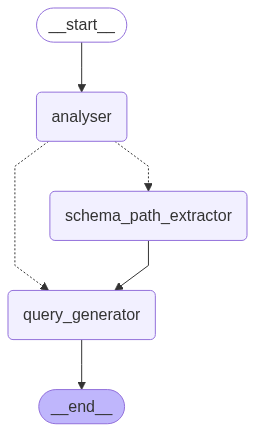

In [171]:
router_graph

#### Run and Evaluate (Estimated Run Time 10-15min)

**Task:** Run your compiled routing graph on a dataset. For each question:

* Instantiate the `RouterGraphState` with the question and schema.
* Run the graph to completion.
* Extract and clean the query from the result.

Use the `run_method` function to handle iteration and timing.

In [180]:

from method_run import run_method
def run_router_graph(item):
    response = router_graph.invoke(
        RouterGraphState(
            question=item['question'],
            schema=item['schema'],
            schema_path=None,
            question_difficulty=None,
            query=None
        )
    )
    result = response["query"]
    # First try to extract query from markdown SQL block
    match = re.search(r'```sql\n(.*?)```', result, re.DOTALL)
    if match:
        query = match.group(1).strip()
    else:
        # If no markdown block found, try to extract just SQL query
        query = result.strip()
        # Remove any ```sql or ``` if present without proper formatting
        query = re.sub(r'```sql|```', '', query).strip()
    print(f"Question: {item['question']}")
    print(f"Schema: {item['schema']}")
    print(f"Question Difficulty: {response['question_difficulty']}")
    if response["schema_path"]:
        print(f"Schema Path: {response['schema_path']}")
    print(f"Generated SQL: {query}\n")
    return {**item, 'sql': query}


run_method(run_router_graph, SLEEP_TIME=30)

#Run on mode=nano if you want to test it on a smaller dataset
# run_method(run_router_graph, SLEEP_TIME=10, mode="nano")

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Question: Find the percentage of atoms with single bond. (Evidence: single bond refers to bond_type = '-'; percentage = DIVIDE(SUM(bond_type = '-'), COUNT(bond_id)) as percentage)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: challenging
Schema Path: ['bond.bond_type', 'bond.bond_id']
Generated SQL: sql
SELECT CAST(SUM(CASE WHEN bond_type = '-' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(bond_id) FROM bond



  6%|████▌                                                                              | 1/18 [00:54<15:19, 54.08s/it]

Question: Indicate which atoms are connected in non-carcinogenic type molecules. (Evidence: label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: moderate
Schema Path: ['molecule.label', 'molecule.molecule_id', 'bond.molecule_id', 'bond.bond_id', 'connected.bond_id', 'connected.atom_id', 'connected.atom_id2']
Generated SQL: sql
SELECT
  T3.atom_id,
  T3.atom_id2
FROM molecule AS T1
INNER JOIN bond AS T2
  ON T1.molecule_id = T2.molecule_id
INNER JOIN connected AS T3
  ON T2.bond_id = T3.bond_id
WHERE
  T1.label = '-'



 11%|█████████▏                                                                         | 2/18 [01:36<12:32, 47.06s/it]

Question: What is the average number of bonds the atoms with the element iodine have? (Evidence: atoms with the element iodine refers to element = 'i'; average = DIVIDE(COUND(bond_id), COUNT(atom_id)) where element = 'i')
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: challenging
Schema Path: ['atom.atom_id', 'atom.element', 'connected.atom_id', 'connected.bond_id']
Generated SQL: sql
SELECT
  AVG(T1.bond_count)
FROM (
  SELECT
    T1.atom_id,
    COUNT(DISTINCT T2.bond_id) AS bond_count
  FROM atom AS T1
  LEFT JOIN connected AS T2
    ON T1.atom_id = T2.atom_id OR T1.atom_id = T2.atom_id2
  WHERE
    T1.element = 'i'
  GROUP BY
    T1.atom_id
) AS T1;



 17%|█████████████▊                                                                     | 3/18 [02:29<12:31, 50.12s/it]

Question: List down two molecule id of triple bond non carcinogenic molecules with element carbon. (Evidence: carbon refers to element = 'c'; triple bond refers to bond_type = '#'; label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: moderate
Schema Path: ['molecule.molecule_id', 'molecule.label', 'bond.bond_type', 'atom.element']
Generated SQL: SELECT T1.molecule_id
FROM molecule AS T1
INNER JOIN bond AS T2
  ON T1.molecule_id = T2.molecule_id
INNER JOIN atom AS T3
  ON T1.molecule_id = T3.molecule_id
WHERE
  T2.bond_type = '#' AND T3.element = 'c' AND T1.label = '-'
LIMIT 2;



 22%|██████████████████▍                                                                | 4/18 [03:08<10:38, 45.62s/it]

Question: What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: moderate
Schema Path: ['atom.element', 'molecule.label', 'molecule.molecule_id', 'atom.molecule_id']
Generated SQL: sql
SELECT T1.element, T2.label FROM atom AS T1 JOIN molecu

 28%|███████████████████████                                                            | 5/18 [03:45<09:12, 42.52s/it]

Question: What are the elements for bond id TR001_10_11? (Evidence: element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: moderate
Schema Path: ['connected', 'atom', 'connected.bond_id', 'connected.atom_id', 'atom.atom_id', 'atom.element']
Generated SQL: sql
SELECT T1.element FROM atom AS T1 JOIN connected AS T2 ON T1.atom_id = T2.atom_id WHERE T2.bond_id = 'TR001_10_11' UNION SELECT T1.element FROM atom AS T1 JOIN connected AS T2 ON T1

 33%|███████████████████████████▋                                                       | 6/18 [04:27<08:26, 42.21s/it]

Question: How many superheroes were published by Dark Horse Comics? (Evidence: published by Dark Horse Comics refers to publisher_name = 'Dark Horse Comics';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Question Difficulty: moderate
Schema Path: ['superhero', 'publisher', 'superhero.publisher_id', 'publisher.publisher_name']
Generated SQL: SELECT
  COUNT(T1.id)
FROM superhero AS T1
INNER JOIN publisher AS T2
  ON T1.publisher_id = T2.id
WHERE
  T2.publisher_name = 'Dark Horse Comics';



 39%|████████████████████████████████▎                                                  | 7/18 [05:03<07:21, 40.17s/it]

Question: What are the race and alignment of Cameron Hicks? (Evidence: Cameron Hicks refers to superhero_name = 'Cameron Hicks';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Question Difficulty: simple
Generated SQL: SELECT
  T2.race,
  T3.alignment
FROM superhero AS T1
INNER JOIN race AS T2
  ON T1.race_id = T2.id
INNER JOIN alignment AS T3
  ON T1.alignment_id = T3.id
WHERE
  T1.superhero_name = 'Cameron Hicks';



 44%|████████████████████████████████████▉                                              | 8/18 [05:38<06:25, 38.55s/it]

Question: Among the superheroes with height from 170 to 190, list the names of the superheroes with no eye color. (Evidence: height from 170 to 190 refers to height_cm BETWEEN 170 AND 190; no eye color refers to eye_colour_id = 1)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Question Difficulty: simple
Generated SQL: SELECT superhero_name
FROM superhero
WHERE height_cm BETWEEN 170 AND 190 AND eye_colour_id = 1;



 50%|█████████████████████████████████████████▌                                         | 9/18 [06:12<05:33, 37.09s/it]

Question: List down at least five superpowers of male superheroes. (Evidence: male refers to gender = 'Male'; superpowers refers to power_name;)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Question Difficulty: moderate
Schema Path: ['gender.gender', 'superhero.gender_id', 'superhero.id', 'hero_power.hero_id', 'hero_power.power_id', 'superpower.id', 'superpower.power_name']
Generated SQL: SELECT T3.power_name
FROM gender AS T1
INNER JOIN superhero AS T2
  ON T1.id = T2.gender_id
INNER JOIN hero_power AS T4
  ON T2.id = T4.hero_id
INNER JOIN superpower AS T3
  ON T4.power_id = T3.id
WHERE
  T1.gender = 'Male'
LI

 56%|█████████████████████████████████████████████▌                                    | 10/18 [06:51<05:02, 37.77s/it]

Question: What is the percentage of superheroes who act in their own self-interest or make decisions based on their own moral code? Indicate how many of the said superheroes were published by Marvel Comics. (Evidence: published by Marvel Comics refers to publisher_name = 'Marvel Comics'; superheroes who act in their own self-interest or make decisions based on their own moral code refers to alignment = 'Bad'; calculation = MULTIPLY(DIVIDE(SUM(alignment = 'Bad); count(id)), 100))
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Question Difficulty: challenging
Schema Path: ['superhero', 'alignment', 'alignment.align

 61%|██████████████████████████████████████████████████                                | 11/18 [07:28<04:23, 37.65s/it]

Question: Which publisher created more superheroes: DC or Marvel Comics? Find the difference in the number of superheroes. (Evidence: DC refers to publisher_name = 'DC Comics'; Marvel Comics refers to publisher_name = 'Marvel Comics'; if SUM(publisher_name = 'DC Comics') > SUM(publisher_name = 'Marvel Comics'), it means DC Comics published more superheroes than Marvel Comics; if SUM(publisher_name = 'Marvel Comics') > SUM(publisher_name = 'Marvel Comics'), it means Marvel Comics published more heroes than DC Comics; difference = SUBTRACT(SUM(publisher_name = 'DC Comics'), SUM(publisher_name = 'Marvel Comics'));)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (i

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [08:07<03:47, 37.86s/it]

Question: Who was the first one paid his/her dues? Tell the full name. (Evidence: full name refers to first_name, last_name; first paid dues refers to MIN(received_date) where source = 'Dues')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Question Difficulty: moderate
Schema Path: ['member.first_name', 'member.last_name', 'income.date_received', 'income.source', 'income.link_to_member', 'member.member_id']
Generated SQL: sql
SELECT
  T1.first_name

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [08:47<03:13, 38.68s/it]

Question: How many income are received with an amount of 50? (Evidence: amount of 50 refers to amount = 50)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Question Difficulty: simple
Generated SQL: SELECT
  COUNT(income_id)
FROM income
WHERE
  amount = 50;



 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [09:21<02:28, 37.22s/it]

Question: Name the event with the highest amount spent on advertisement. (Evidence: event refers to event_name; highest amount spent on advertisement refers to MAX(spent) where category = 'Advertisement')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Question Difficulty: moderate
Schema Path: ['event.event_name', 'budget.spent', 'budget.category', 'budget.link_to_event']
Generated SQL: sql
SELECT T1.event_name
FROM event AS T1
INNER JOIN budget AS

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [10:00<01:53, 37.74s/it]

Question: Based on the total cost for all event, what is the percentage of cost for Yearly Kickoff event? (Evidence: DIVIDE(SUM(cost where event_name = 'Yearly Kickoff'), SUM(cost)) * 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Question Difficulty: challenging
Schema Path: ['expense.cost', 'event.event_name', 'expense.link_to_budget', 'budget.link_to_event']
Generated SQL: SELECT
  SUM(CASE WHEN T3.event_name = 'Yearly Kickoff' THEN T1.cost

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [10:39<01:15, 37.99s/it]

Question: Calculate the total average cost that Elijah Allen spent in the events on September and October. (Evidence: events in September and October refers to month(expense_date) = 9 AND MONTH(expense_date) = 10)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Question Difficulty: moderate
Schema Path: ['expense.cost', 'expense.expense_date', 'expense.link_to_member', 'expense.link_to_budget', 'member.first_name', 'member.last_name', 'member.member

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [11:20<00:39, 39.07s/it]

Question: Find the name and date of events with expenses for pizza that were more than fifty dollars but less than a hundred dollars. (Evidence: name of event refers to event_name; date of event refers to event_date; expenses for pizza refers to expense_description = 'Pizza' where cost > 50 and cost < 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Question Difficulty: moderate
Schema Path: ['event', 'event.event_name', 'event.event_date', 'exp

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [11:58<00:00, 39.94s/it]


Starting to compare without knowledge for ex
Process finished successfully
start calculate
                     simple               moderate             challenging          total               
count                6                    6                    6                    18                  
======================================    ACCURACY    =====================================
accuracy             16.67                50.00                50.00                38.89               
Finished evaluation



### Agent (ReAct)

Now you will implement a full ReAct agent that incrementally solves the Text-to-SQL task using tools. The agent can explore tables and columns before finalizing the query.

**You are not allowed to use 'Prebuilt Agent' of LangGraph. You have to build your own graph.**

#### Define Tools

**Task:** Define three tools for the agent to interact with the schema:
1. `get_samples_from_table`: Returns the first few rows of a table.
2. `get_column_description`: Provides a human-readable description of a specific column.
3. `execute`: Executes a SQL query.

In [ ]:
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode

from db_manager import DBManager
db_manager = DBManager()

@tool
def get_samples_from_table(table_name: str, config: RunnableConfig):
  """Gets the first few rows (samples) from a specified table.

  Args:
    table_name: The name of the table from which to fetch samples.

  Returns:
    The first few rows from the specified table.
  """
  db_name = config["configurable"].get("database_name")
  result = db_manager.get_table_head(table_name, db_name=db_name)
  return result

@tool
def get_column_description(table_name: str, column_name: str, config: RunnableConfig):
  """Provides a description for a specific column within a given table.

  Args:
    table_name: The name of the table containing the column.
    column_name: The name of the column for which to get the description.

  Returns:
    A string containing the description of the specified column.
  """
  db_name = config["configurable"].get("database_name")
  result = db_manager.get_column_description(db_name, table_name, column_name)
  return result

@tool
def execute(query: str, config: RunnableConfig):
  """Executes a given SQL query against the database.

  Args:
    query: The SQL query string to be executed.

  Returns:
    The result of the executed query. This could be a set of rows,
    a confirmation message, or an error.
  """
  db_name = config["configurable"].get("database_name")
  result = db_manager.query(query, db_name)
  return result

#### Extra Tool (5+5 Bonus Points):

**Task**: Create and integrate a new custom tool into the ReAct agent. To receive credit for this part, your tool must be meaningfully different from the existing three tools and provide practical value in helping the agent generate more accurate or efficient SQL queries.

In [ ]:
#YOUR CODE HERE

#### Create Tool Node

In [ ]:
tools = [get_samples_from_table, get_column_description, execute]
tools_node = ToolNode(tools=tools)

#### ReAct Agent Prompt (5 Points)

**Task:** Set up the agent node with planning, tool use, and final SQL generation prompts. For writing efficient prompt you can read this link.
https://cookbook.openai.com/examples/gpt4-1_prompting_guide

In [ ]:
REACT_SYS_PROMPT = """
#YOUR PROMPT HERE
"""


#### Agent Node (5 Points)

**Task:** Set up the agent node with models that have binded with tools.

In [ ]:
import time

def agent_node(state: MessagesState) -> MessagesState:
    #For rate-limiting purposes, we will sleep for 10 seconds before invoking the LLM
    time.sleep(10)
    #YOUR CODE HERE
    return state

#### Build Graph (5 Points)

**Task:** Assemble the ReAct agent graph, connecting the agent node and tool node.

In [ ]:
from langgraph.prebuilt import tools_condition
from typing_extensions import TypedDict

class ConfigSchema(TypedDict):
    database_name: str

react_builder = StateGraph(MessagesState, config_schema=ConfigSchema)

#YOUR CODE HERE

react_graph = react_builder.compile()


#### Run and Evaluate (Estimated Run Time 20min)

**Task:** Execute the ReAct agent pipeline on the dataset and collect SQL outputs.

In [ ]:
from method_run import run_method
import re
def run_react_agent_with_config(item):
    question = item['question']
    schema = item['schema']
    user_prompt = f"Question: {question}\nSchema: {schema}"
    input_msg = HumanMessage(content=user_prompt)
    input_config = {"configurable": {"database_name": item['db_id']}}
    response = react_graph.invoke(MessagesState(messages=[input_msg]), config=input_config)

    for msg in response["messages"]:
        msg.pretty_print()
        
    # If last AI Message is a list of messages, we need to extract the last one
    last_msg = response["messages"][-1].content
    if isinstance(last_msg, list):
        last_msg = last_msg[-1]

    # First try to extract query from markdown SQL block
    match = re.search(r'```sql\n(.*?)```', last_msg, re.DOTALL)
    if match:
        query = match.group(1).strip()
    else:
        # If no markdown block found, try to extract just SQL query
        query = last_msg.strip()
        # Remove any ```sql or ``` if present without proper formatting
        query = re.sub(r'```sql|```', '', query).strip()

    return {**item, 'sql': query}

#Run agent on mode=nano, it's not needed to run on full dataset
run_method(run_react_agent_with_config, SLEEP_TIME=20, mode="nano")